# Final Project - Machine Learning

In this project, we consider the following dataset: 
https://www.kaggle.com/datasets/camnugent/california-housing-prices.
It contains information about blocks of houses in california. The goal is to predict the median house prices within a block using multiple methods of regression.

We start by importing the main libraries.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import torch
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV

Next we import the dataset and read it using pandas.

In [2]:
df=pd.read_csv("housing.csv")

In [3]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
longitude,20640.0,-119.569704,2.003532,-124.3500,-121.8000,-118.4900,-118.01000,-114.3100
latitude,20640.0,35.631861,2.135952,32.5400,33.9300,34.2600,37.71000,41.9500
housing_median_age,20640.0,28.639486,12.585558,1.0000,18.0000,29.0000,37.00000,52.0000
total_rooms,20640.0,2635.763081,2181.615252,2.0000,1447.7500,2127.0000,3148.00000,39320.0000
total_bedrooms,20433.0,537.870553,421.385070,1.0000,296.0000,435.0000,647.00000,6445.0000
population,20640.0,1425.476744,1132.462122,3.0000,787.0000,1166.0000,1725.00000,35682.0000
households,20640.0,499.539680,382.329753,1.0000,280.0000,409.0000,605.00000,6082.0000
median_income,20640.0,3.870671,1.899822,0.4999,2.5634,3.5348,4.74325,15.0001
median_house_value,20640.0,206855.816909,115395.615874,14999.0000,119600.0000,179700.0000,264725.00000,500001.0000


As we can see, the dataset has 10 features:
1. longitude: A measure of how far west a house is; a higher value is farther west
2. latitude: A measure of how far north a house is; a higher value is farther north
3. housingMedianAge: Median age of a house within a block; a lower number is a newer building
4. totalRooms: Total number of rooms within a block
5. totalBedrooms: Total number of bedrooms within a block
6. population: Total number of people residing within a block
7. households: Total number of households, a group of people residing within a home unit, for a block
8. medianIncome: Median income for households within a block of houses (measured in tens of thousands of US Dollars)
9. medianHouseValue: Median house value for households within a block (measured in US Dollars)
10. oceanProximity: Location of the house w.r.t ocean/sea

The feature we are trying to predict is the medianHouseValue.

We start by preprocessing the data and plotting some graphs in order to better understand the data.

### Data Analysis and Preprocessing

In [5]:
df.shape

(20640, 10)

So we have a total of 20640 datapoints to work with.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


We can see that there are a few null values in the total_bedrooms column. We replace these values with the median.

In [7]:
df["total_bedrooms"] = df["total_bedrooms"].fillna(df["total_bedrooms"].median())

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20640 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


We check for NaN values in the dataset:

In [9]:
df.isna().sum().values.sum()

0

So there are none anymore. 

Next we do label encoding on ocean_proximity, since it is the only feature that is not a number:

In [10]:
print(df[['ocean_proximity']].value_counts())

ocean_proximity
<1H OCEAN          9136
INLAND             6551
NEAR OCEAN         2658
NEAR BAY           2290
ISLAND                5
Name: count, dtype: int64


We can drop the rows that are have 'ISLAND' as ocean proximity since the very low number of such rows (5) could have a negative or no impact on the predictions. This is especially important since we can expect prices of houses on Islands to be very different from houses on land.

In [11]:
df = df[df['ocean_proximity'] != 'ISLAND']
print(df[['ocean_proximity']].value_counts())

ocean_proximity
<1H OCEAN          9136
INLAND             6551
NEAR OCEAN         2658
NEAR BAY           2290
Name: count, dtype: int64


Before we encode the other rows lets show a boxplot using seaborn to better understand the relation of ocean_proximity with the target attribute.

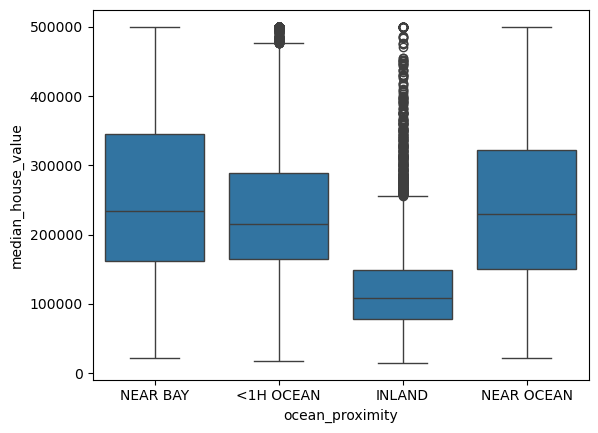

In [12]:
sns.boxplot(x='ocean_proximity',y='median_house_value',data=df)
plt.show()

We can expect that the main difference will be wether the house is inland or not. We use sklearns one-hot encoder to encode the data.

In [13]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)  # sparse_output=False returns a dense array

# Fit and transform the categorical columns
encoded_features = encoder.fit_transform(df[['ocean_proximity']])

# Convert the result to a DataFrame for better readability
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(['ocean_proximity']))

# Combine the one-hot encoded features with the original numerical features
df = pd.concat([encoded_df, df.drop('ocean_proximity',axis=1).reset_index(drop=True)], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20635 entries, 0 to 20634
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ocean_proximity_<1H OCEAN   20635 non-null  float64
 1   ocean_proximity_INLAND      20635 non-null  float64
 2   ocean_proximity_NEAR BAY    20635 non-null  float64
 3   ocean_proximity_NEAR OCEAN  20635 non-null  float64
 4   longitude                   20635 non-null  float64
 5   latitude                    20635 non-null  float64
 6   housing_median_age          20635 non-null  float64
 7   total_rooms                 20635 non-null  float64
 8   total_bedrooms              20635 non-null  float64
 9   population                  20635 non-null  float64
 10  households                  20635 non-null  float64
 11  median_income               20635 non-null  float64
 12  median_house_value          20635 non-null  float64
dtypes: float64(13)
memory usage: 2.

Let us check the data with describe:

In [14]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ocean_proximity_<1H OCEAN,20635.0,0.442743,0.496723,0.0000,0.0000,0.0000,1.0000,1.0000
ocean_proximity_INLAND,20635.0,0.317470,0.465503,0.0000,0.0000,0.0000,1.0000,1.0000
ocean_proximity_NEAR BAY,20635.0,0.110976,0.314111,0.0000,0.0000,0.0000,0.0000,1.0000
ocean_proximity_NEAR OCEAN,20635.0,0.128810,0.334998,0.0000,0.0000,0.0000,0.0000,1.0000
longitude,20635.0,-119.569999,2.003685,-124.3500,-121.8000,-118.5000,-118.0100,-114.3100
latitude,20635.0,35.632412,2.135918,32.5400,33.9300,34.2600,37.7100,41.9500
housing_median_age,20635.0,28.636152,12.583924,1.0000,18.0000,29.0000,37.0000,52.0000
total_rooms,20635.0,2636.020208,2181.794772,2.0000,1448.0000,2127.0000,3148.0000,39320.0000
total_bedrooms,20635.0,536.867071,419.432146,1.0000,297.0000,435.0000,644.0000,6445.0000
population,20635.0,1425.660286,1132.530137,3.0000,787.0000,1166.0000,1725.0000,35682.0000


Here is a scatterplot of the distribution of each feature with respect to the median_house_value.

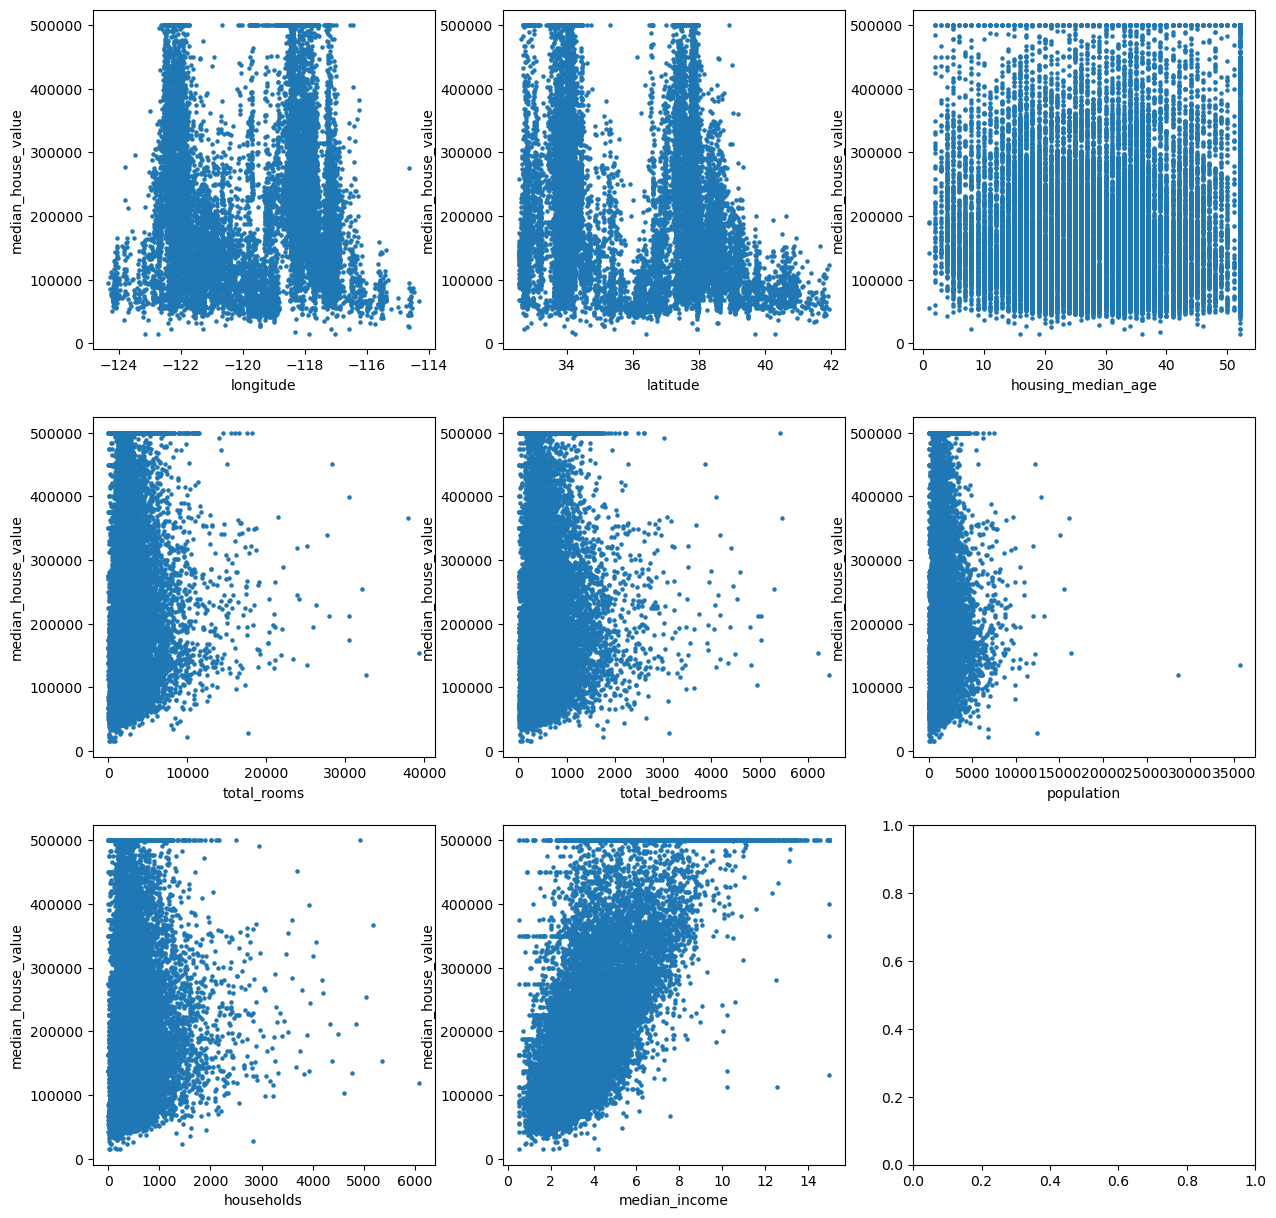

In [15]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15)) #creating 3x3 plots, last one will be empty

#plotting the data
for idx, feature in enumerate(df.iloc[:,4:-1].columns):
    df.plot(feature, "median_house_value",  kind="scatter", ax=axes[idx // 3, idx % 3],marker='.') 
plt.show()

The feature median_income seems to be correlated with the prices (which makes a lot of sence), so we can expect it to play an important role in the predictions.

Next we compute the correlation matrix to better understand the data.

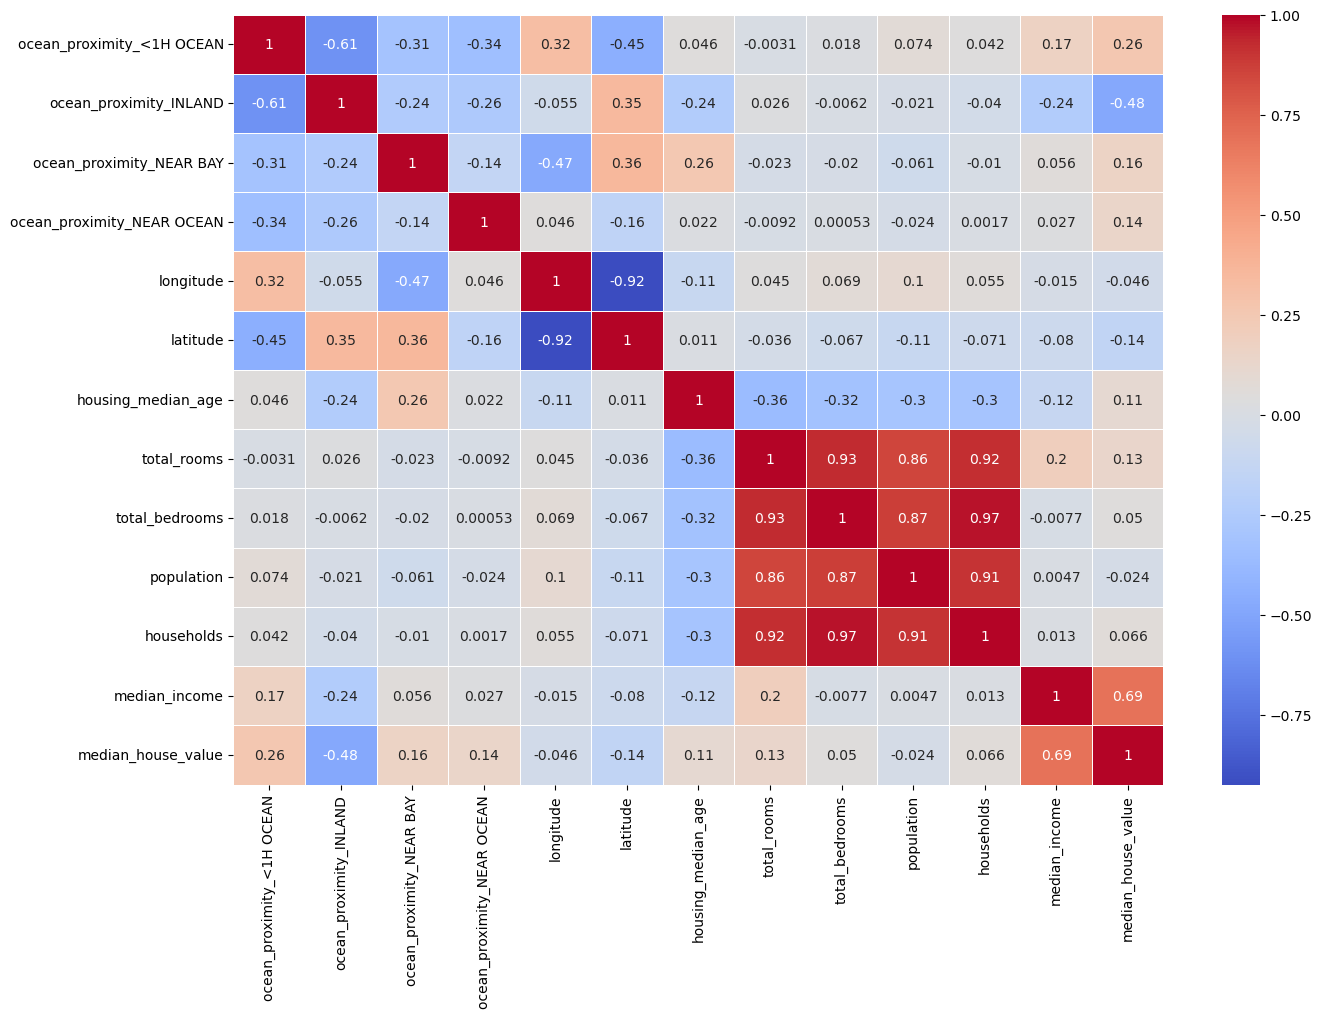

In [16]:
plt.figure(figsize = (15,10))
sns.heatmap(df.corr(method='pearson'), annot=True,linewidths=.5, cmap="coolwarm")
plt.show()

We can see a almost one-to-one correlation between households and total bedrooms and will therefore drop the total_bedroom column. There is also a very strong correlation between total rooms and total bedrooms but we will try to work with both.

In [17]:
df.drop('households',axis=1,inplace=True)

We also print the exact values of the correlation of each attribute with the target attribute.

In [18]:
df.iloc[:,:-1].corrwith(df['median_house_value'], axis=0, method='pearson')

ocean_proximity_<1H OCEAN     0.257049
ocean_proximity_INLAND       -0.484794
ocean_proximity_NEAR BAY      0.160467
ocean_proximity_NEAR OCEAN    0.142051
longitude                    -0.046208
latitude                     -0.143837
housing_median_age            0.105272
total_rooms                   0.134373
total_bedrooms                0.049561
population                   -0.024421
median_income                 0.688563
dtype: float64

We will not use PCA or an other dimenionality reduction method since we already have a low number of features.

Next we do a train test split. We will use 80% of the data for training and 20% for testing. We will only use the test set at the end of each section in order to compare the efficiency of the different methods. We will not split the train set into a train and validation set yet since we will also be using crossvalidation.

In [19]:
from sklearn.model_selection import train_test_split
fraction_train = 0.8
fraction_test = 1.0 - fraction_train
df_train, df_test = train_test_split(df, train_size = fraction_train, test_size = fraction_test,random_state=0)
print(df_train.shape)
df_test.shape

(16508, 12)


(4127, 12)

Next, we separate the target feature from the rest.

In [20]:
y_train=df_train['median_house_value']
x_train=df_train.drop('median_house_value',axis=1)

y_test=df_test['median_house_value']
x_test=df_test.drop('median_house_value',axis=1)

Finally, we use sklearns standardiser to standardize x_train and x_test:

In [21]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Fit and transform the features
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test) # we apply the same transformation on the test data.


# Restore the DataFrames
x_train = pd.DataFrame(x_train_scaled, columns=x_train.columns)
x_test = pd.DataFrame(x_test_scaled, columns=x_test.columns)

In [22]:
x_train.describe().T

,count,mean,std,min,25%,50%,75%,max
ocean_proximity_<1H OCEAN,16508.0,7.169238e-17,1.00003,-0.889185,-0.889185,-0.889185,1.124626,1.124626
ocean_proximity_INLAND,16508.0,7.801422e-19,1.00003,-0.682697,-0.682697,-0.682697,1.464780,1.464780
ocean_proximity_NEAR BAY,16508.0,8.393254e-18,1.00003,-0.353095,-0.353095,-0.353095,-0.353095,2.832096
ocean_proximity_NEAR OCEAN,16508.0,-2.152116e-19,1.00003,-0.386034,-0.386034,-0.386034,-0.386034,2.590447
longitude,16508.0,3.104858e-15,1.00003,-2.389072,-1.110986,0.536548,0.781181,2.543543
latitude,16508.0,1.684246e-15,1.00003,-1.445971,-0.794826,-0.644922,0.975912,2.962137
housing_median_age,16508.0,-1.148154e-16,1.00003,-2.194559,-0.844101,0.029725,0.665234,1.856815
total_rooms,16508.0,-1.062607e-16,1.00003,-1.215256,-0.546089,-0.231867,0.237845,16.979986
total_bedrooms,16508.0,-8.716071e-18,1.00003,-1.284563,-0.573715,-0.238772,0.255207,13.676994
population,16508.0,7.182688e-18,1.00003,-1.271041,-0.568397,-0.224254,0.269975,30.746378


In [23]:
x_test.describe().T

,count,mean,std,min,25%,50%,75%,max
ocean_proximity_<1H OCEAN,4127.0,0.012077,1.001469,-0.889185,-0.889185,-0.889185,1.124626,1.124626
ocean_proximity_INLAND,4127.0,-0.004683,0.998277,-0.682697,-0.682697,-0.682697,1.464780,1.464780
ocean_proximity_NEAR BAY,4127.0,0.001929,1.002508,-0.353095,-0.353095,-0.353095,-0.353095,2.832096
ocean_proximity_NEAR OCEAN,4127.0,-0.013162,0.985417,-0.386034,-0.386034,-0.386034,-0.386034,2.590447
longitude,4127.0,-0.013223,1.001653,-2.364109,-1.125963,0.521570,0.771196,2.623423
latitude,4127.0,0.013338,1.002771,-1.431917,-0.794826,-0.635553,0.980596,2.910607
housing_median_age,4127.0,0.004105,0.998246,-2.194559,-0.844101,0.029725,0.665234,1.856815
total_rooms,4127.0,0.018463,1.047346,-1.213405,-0.546321,-0.233256,0.249415,16.339973
total_bedrooms,4127.0,0.033462,1.051936,-1.282154,-0.561666,-0.238772,0.300991,14.243263
population,4127.0,0.028089,1.078779,-1.266554,-0.563013,-0.234574,0.293083,24.360662


As expected the mean are now very close to 0 and the standard deviation to 1.

In the next section we start making predictions using least square regression.

# Least Square Regression

In this section we will perform least square regression on our dataset using a ridge penaltie. We will use cross validation in order to find the best coefficient for the penalty.

First we look at the effect of the penalty on the coefficients in order to find a good interval we will be searching in.

In [24]:
from sklearn.linear_model import Ridge

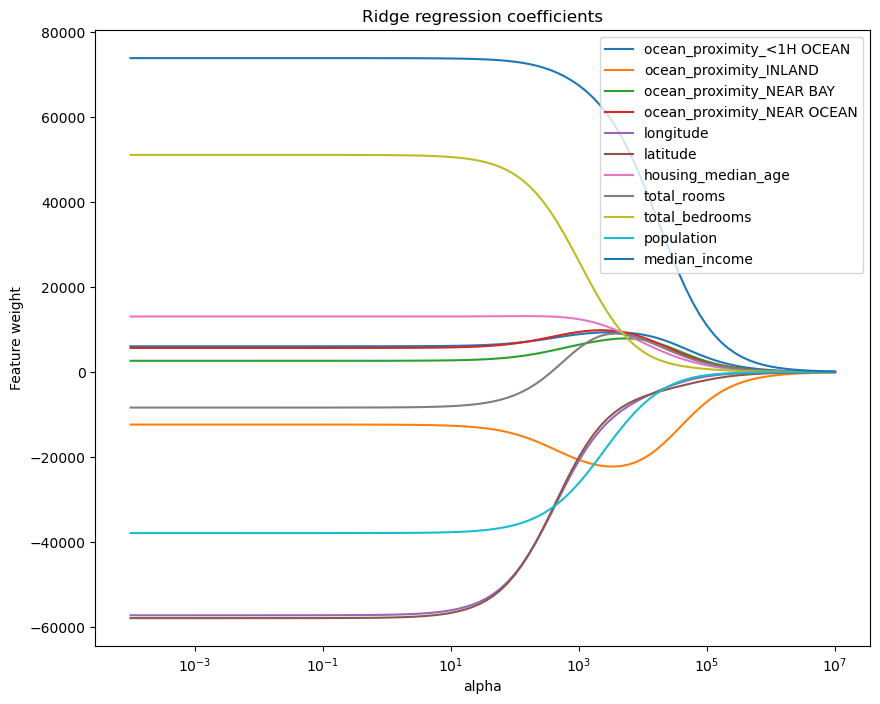

In [25]:
#We take a very big range of alphas (the coefficients of the penalty)
alphas_ridge = np.logspace(-4, 7, 100)

#we will store the coefficients into this array
coefs_ridge = np.zeros((alphas_ridge.shape[0], x_train.shape[1]))

#enumerating the alphas
for i, a in enumerate(alphas_ridge): 

    #initializing model with corresponding alpha
    ridge = Ridge(alpha = a) 

    #fitting the data
    ridge.fit(x_train, y_train)

    #saving coefficients
    for j, coef in enumerate(ridge.coef_):
        coefs_ridge[i][j] = coef

#plotting the coefficients w.r.t. the alphas
plt.figure(figsize=(10, 8))
for coef, feature in zip(coefs_ridge.T, x_train.columns):
    plt.semilogx(alphas_ridge, coef, label=feature)
plt.legend(loc="upper right")
plt.xlabel("alpha")
plt.ylabel("Feature weight")
plt.title("Ridge regression coefficients")
plt.show()

So the ideal value of alpha will most likely be in the range $10^{-1}$ to $10^{3}$. We now use Crossvalidation to determine this ideal value.
Since our dataset is small we will use cv=none, i.e. use a leave-one-out method and choose the ideal value based on the MSE.

In [26]:
from sklearn.linear_model import RidgeCV

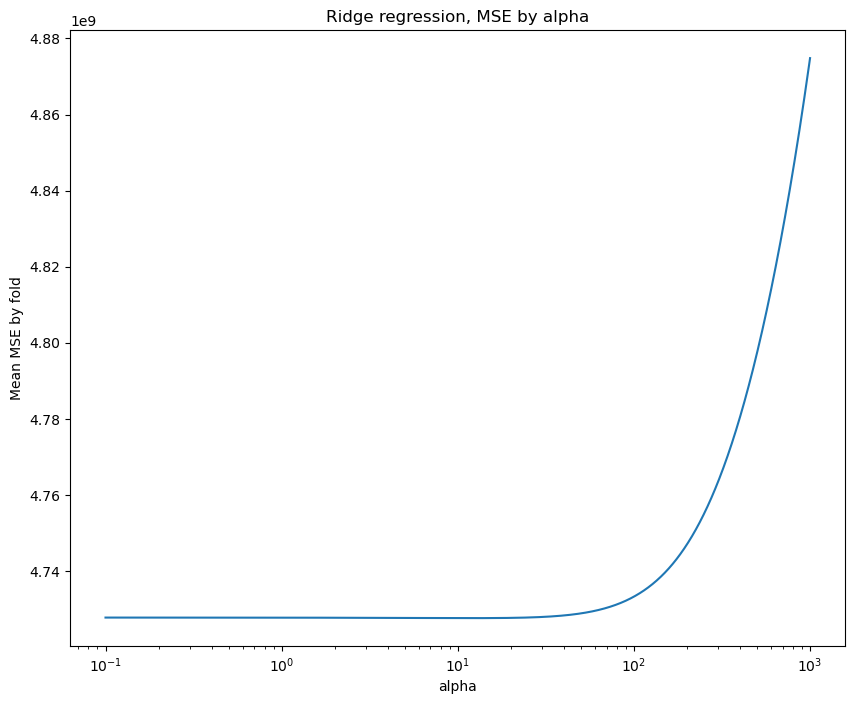

In [27]:
alphas_ridge = np.logspace(-1, 3, 2000)

# initializing the model
ridge = RidgeCV(cv=None, alphas = alphas_ridge, scoring=None, store_cv_results=True)

#fitting the model
ridge.fit(x_train, y_train)

#We plot the Mean MSE by fold for each alpha:
plt.figure(figsize=(10, 8)) 
plt.semilogx(alphas_ridge, np.array(ridge.cv_results_).mean(axis=0) , label=feature )
plt.xlabel("alpha")
plt.ylabel("Mean MSE by fold")
plt.title("Ridge regression, MSE by alpha")
plt.show()

In [28]:
print('Regularizator\'s R2 score (train):', ridge.score(x_train, y_train))
print('Regularizator\'s MSE (train) :', ridge.cv_results_.mean(axis=0).min())
print('Regularizator\'s optimal value:', ridge.alpha_)

Regularizator's R2 score (train): 0.6466844304157127
Regularizator's MSE (train) : 4727618907.790675
Regularizator's optimal value: 11.996084596855525


Finally we compute the R2 score for the test set.

In [140]:
print(f'Best R2 score for ridge regression: {ridge.score(x_test, y_test)}')

Best R2 score for ridge regression: 0.6278981503751229


We also compute the sqare root of the mean squared error and the mean absolute error, which will be give more information about the quality of the predictions:

In [30]:

y_pred_ridge=ridge.predict(x_test)

# Calculate the real MSE
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
mae_ridge= mean_absolute_error(y_test, y_pred_ridge)
print(f'Real Test sqrt(MSE): {np.sqrt(mse_ridge)}')
print(f'Real Test MSE: {mae_ridge}')

Real Test sqrt(MSE): 70179.49393156345
Real Test MSE: 50300.52028714864


We remind how the y_test dataset looks like:

In [32]:
df_test['median_house_value'].describe()

count      4127.000000
mean     205820.227768
std      115062.005764
min       22500.000000
25%      118600.000000
50%      178400.000000
75%      261150.000000
max      500001.000000
Name: median_house_value, dtype: float64

So an absolute error of 50000 is not great.

Next we take a look at trees and random forest for predictions.

# Trees, Random Forest and XGBoost

The dataset has been standardized, and although it is not necessary for trees and random forest, it also should have no impact on the results, so for the sake of simplicity we will keep working on the standardized dataset.

We start by plotting a small tree to see what the most important splits are.

In [33]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

In [141]:
#constructing and fitting the model
dt = DecisionTreeRegressor(max_depth=3) 
model = dt.fit(x_train,y_train)

#We print the R2 score
R2 = dt.score(x_train,y_train)
print('R2  (train):',R2)

R2  (train): 0.5731090688848474


Number of data points :  16508
X[ 0 ] =  ocean_proximity_<1H OCEAN
X[ 1 ] =  ocean_proximity_INLAND
X[ 2 ] =  ocean_proximity_NEAR BAY
X[ 3 ] =  ocean_proximity_NEAR OCEAN
X[ 4 ] =  longitude
X[ 5 ] =  latitude
X[ 6 ] =  housing_median_age
X[ 7 ] =  total_rooms
X[ 8 ] =  total_bedrooms
X[ 9 ] =  population
X[ 10 ] =  median_income


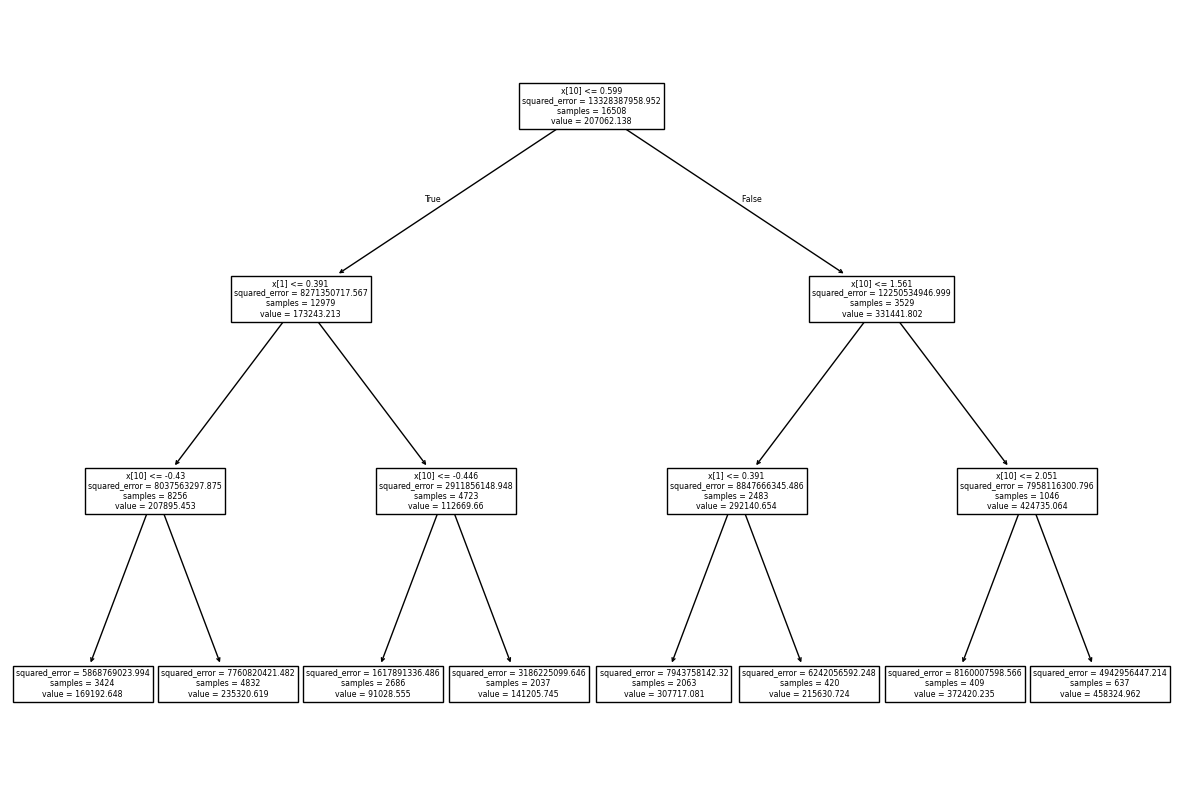

In [35]:
from sklearn import tree
print('Number of data points : ',y_train.shape[0])
for pair in zip(x_train.columns, np.arange(df_train.shape[0])):
  print('X[',pair[1],'] = ', pair[0]) 
plt.figure(figsize=(15, 10))
tree.plot_tree(dt)
plt.show()

As expected when looking at the correlation matrix, the most important splits occure on the median income and ocean proximity(mainly whether the house is inland or not). The R2 error above is not terrible for a single tree but still not as good as the outcome of the linear models (even though we only considered the training error here).

Next we use GridSearchCV to find the optimal parameters of maximal depth and the minimum number of samples required to be at a leaf node by using crossvalidation. We use the default 5-fold crossvalidation.

In [36]:
dt = DecisionTreeRegressor()
dt_params = {'max_depth':np.arange(1,10),'min_samples_leaf':np.arange(1,20)}

In [37]:
#defining the model
gs_dt = GridSearchCV(dt, dt_params)
#fitting the model
gs_dt.fit(x_train,y_train)

a = gs_dt.best_params_ # best parameters in form of a dictionary
print('- Best maximal depth =',a['max_depth'])
print('- Best minimal number of samples in the leaves = ',a['min_samples_leaf'],'\n')

- Best maximal depth = 9
- Best minimal number of samples in the leaves =  14 



The execution of this cell takes a long time, so in order not to rerun the cell we save the optimal parameters:

In [55]:
a['max_depth']=9
a['min_samples_leaf']=14

Next we train the model with our optimal parameters and evaluate it using our test set.

In [38]:
# training with best parameters
dt_final = DecisionTreeRegressor(max_depth=a['max_depth'],min_samples_leaf=a['min_samples_leaf'])
model = dt_final.fit(x_train,y_train)

# Making predictions
y_pred = model.predict(x_test)

#We print the sqrt(MSE), mae and the R2 score
mse = mean_squared_error(y_pred,y_test)
print('sqrt(MSE) (test):',np.sqrt(mse)) 
mae =mean_absolute_error(y_pred,y_test)
print('MAE (test):',mae)
R2 = dt_final.score(x_test,y_test)
print('R2  (test):',R2)

sqrt(MSE) (test): 58408.47316722136
MAE (test): 39907.50795630677
R2  (test): 0.7422533248115234


These predictions are a lot better than the one of ridge penalization.

Next, instead of controling the max_depth and min_sample_leaf parameters to avoid overfitting we consier a different approche: pruning. More precisely, we will prune the tree using the cost complexity parameter, ccp_alpha. Greater values of ccp_alpha increase the number of nodes pruned.

We start by using DecisionTreeRegressor.cost_complexity_pruning_path to get a list of effective alphas from which we will choose an optimal alpha for the test error.

In [39]:
clf = DecisionTreeRegressor()
path = clf.cost_complexity_pruning_path(x_train, y_train)
ccp_alphas, _ = path.ccp_alphas, path.impurities

In [40]:
ccp_alphas.shape

(14465,)

The range of alphas to consider is very big, so doing crossvalidation to find the optimal parameter could take a very long time. Therefore we reduce this interval. Note that the alphas are ordered so we can simply take every 100th element.

In [41]:
ccp_alphas=ccp_alphas[::100]
ccp_alphas.shape

(145,)

This range of alphas is of a more acceptable size. We use GridSearchCV once again to find the optimal parameter. We use a 4-fold crossvalidation (cv=4)

In [42]:
#initializing model
ccp_params = {'ccp_alpha':ccp_alphas}
gs_ccp = GridSearchCV(clf,ccp_params, cv=4) 
#fitting model
gs_ccp.fit(x_train,y_train)
c = gs_ccp.best_params_ 
print('- Best alpha = ',c['ccp_alpha'])

- Best alpha =  9643682.617379569


The execution of this cell takes a long time, so in order not to rerun the cell we save the optimal parameters:

In [ ]:
c['ccp_alpha']= 9643682.617379569

We then evaluate our model using the test set.

In [43]:
#Creating and fitting the model
clf=DecisionTreeRegressor(random_state=0, ccp_alpha=c['ccp_alpha'])
clf.fit(x_train,y_train)

# making predictions
y_pred = clf.predict(x_test)

#We print the sqrt(MSE), MAE and the R2 score
mse = mean_squared_error(y_pred,y_test)
print('sqrt(MSE) (test):',np.sqrt(mse)) 
mae =mean_absolute_error(y_pred,y_test)
print('MAE (test):',mae)
R2 = dt_final.score(x_test,y_test)
print('R2  (test):',R2)

sqrt(MSE) (test): 59648.14305147036
MAE (test): 42140.47344275855
R2  (test): 0.7422533248115234


These results are a bit worse than the previous ones.

Next we consider Random Forests. We start by finding good parameters for n_estimators, max_depth and min_sample_leaf.

In [44]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()

In [45]:
#initializing model
rf_params = {'n_estimators':np.arange(85,160,15),'max_depth':np.arange(1,11,2),'min_samples_leaf':np.arange(2,15,3)}
gs_rf = GridSearchCV(rf,rf_params) 

# fitting model
gs_rf.fit(x_train,y_train)

#extracting and printing best parameters
b = gs_rf.best_params_ 

print('- Best number of trees = ',b['n_estimators'])
print('- Best maximal depth =', b['max_depth'])
print('- Best minimal number of samples in the leaves = ',b['min_samples_leaf'],'\n')

- Best number of trees =  100
- Best maximal depth = 9
- Best minimal number of samples in the leaves =  5 



The execution of this cell takes a long time, so in order not to rerun the cell we save the optimal parameters:

In [46]:
b['n_estimators']=100
b['max_depth']=9
b['min_samples_leaf']=5

Next we train the model with our optimal parameters and evaluate it using our test set.

In [48]:
# Initializing and fitting the model
rf_final = RandomForestRegressor(n_estimators=b['n_estimators'],max_depth=b['max_depth'],min_samples_leaf=b['min_samples_leaf'])
model = rf_final.fit(x_train,y_train)

#making predictions
y_pred = model.predict(x_test)

#printing the sqrt(MSE), MAE and the R2 score
mse = mean_squared_error(y_pred,y_test)
print('sqrt(MSE) (test):',np.sqrt(mse)) 
mae =mean_absolute_error(y_pred,y_test)
print('MAE (test):',mae)
R2 = rf_final.score(x_test,y_test)
print('R2  (test):',R2)

sqrt(MSE) (test): 54196.78404107723
MAE (test): 37148.77508711768
R2  (test): 0.7780841111183123


We get a test MAE of 37000 which is a good improvement to the result of a single Tree.

Finally we use XGBoost to make predictions. We start by using a model with default parameters

In [49]:
from xgboost import XGBRegressor

In [50]:
xgb = XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=7)
xgb.fit(x_train.values, y_train.values)
y_pred_xgb = xgb.predict(x_test)

print("XGBoost R² Score:", r2_score(y_test, y_pred_xgb))
print(np.sqrt(mean_squared_error(y_pred_xgb,y_test)))
print(sklearn.metrics.mean_absolute_error(y_pred_xgb,y_test))

XGBoost R² Score: 0.8471185477812448
44983.8598551407
29150.232705828235


The test MAE already decreased by around 8000 in comparasaison to the previous result, which is about a 20% decrease.

To see if we can further improve this model, we use GridSearchCV to find better parameters. The parameters we consider are the following:
'n_estimators', 'max_depth', 'learning_rate', 'subsample', 'colsample_bytree'.
The 'subsample' parameter specifies the fraction of samples to be used for growing each individual tree and the 'colsample_bytree' parameter specifies the fraction of features (columns) to be randomly sampled for each tree.

In [51]:
xgb = XGBRegressor()

# Define the parameter grid
xgb_params = {
    'n_estimators': [100, 200, 400],
    'max_depth': [4, 8, 12],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

# Initializing GridSearchCV with the correct parameters
gs_xgb = GridSearchCV(estimator=xgb, param_grid=xgb_params, cv=3, scoring='r2')

# Fitting the model
gs_xgb.fit(x_train.values, y_train)

GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, feature_weights=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None, ...),
             param_grid={'colsample_bytree': [0.7, 0.8, 0.9],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [4, 8, 12],
                         'n_estimators': [100, 200, 400],
                         'subsample': [0.7, 0.8, 0.9]},
             scoring='r2')

We print the optimal parameters we found:

In [52]:
best_params=gs_xgb.best_params_
print('- Best number of trees = ',best_params['n_estimators'])
print('- Best maximal depth =', best_params['max_depth'])
print('- Best learning rate = ',best_params['learning_rate'])
print('- Best subsamples = ',best_params['subsample'])
print('- Best column samples by tree = ',best_params['colsample_bytree'],'\n')

- Best number of trees =  400
- Best maximal depth = 8
- Best learning rate =  0.05
- Best subsamples =  0.9
- Best column samples by tree =  0.7 



Once again we save them in order not to have to rerun the cells.

In [ ]:
best_params['n_estimators']=400
best_params['max_depth']=8
best_params['learning_rate']=0.05
best_params['subsample']=0.9
best_params['colsample_bytree']=0.7

Finally, we train the model with these optimal parameters.

In [144]:
xgb = XGBRegressor(n_estimators=best_params['n_estimators'],max_depth=best_params['max_depth'],learning_rate=best_params['learning_rate'],
                   subsample=best_params['subsample'],colsample_bytree=best_params['colsample_bytree'])
xgb.fit(x_train.values, y_train.values)
y_pred_xgb = xgb.predict(x_test)

print("XGBoost R2 Score:", r2_score(y_test, y_pred_xgb))
print(np.sqrt(mean_squared_error(y_pred_xgb,y_test)))
print(sklearn.metrics.mean_absolute_error(y_pred_xgb,y_test))

XGBoost R2 Score: 0.8488895643563371
44722.548795482944
29046.6068818906


We barelly increased the test performance compared to the other XGBoost model we considered. However, this is the best performing model yet.

In the next section we try to further improve the predictions using neural networks.

# Neural Networks

In this section we use feed foward neural networks to try and make our predictions. I optimized the model architure by hand and ended up using a model with a single hidden layer. 

We start by importing the model we will use:

In [57]:
import torch.nn as nn

Next we convert the pandas dataframes into torch tensors.

In [58]:
X_train_full = torch.Tensor(x_train.to_numpy())
Y_train_full = torch.Tensor(y_train.to_numpy())
X_test = torch.Tensor(x_test.to_numpy())
Y_test = torch.Tensor(y_test.to_numpy())

In [59]:
Y_train_full=Y_train_full.reshape(Y_train_full.shape[0],1)
Y_test=Y_test.reshape(Y_test.shape[0],1)

In [60]:
print("shape of X:",X_train_full.shape)
print("shape of Y:",Y_train_full.shape)

shape of X: torch.Size([16508, 11])
shape of Y: torch.Size([16508, 1])


In [61]:
Y_train_full.shape

torch.Size([16508, 1])

In [62]:
Y_test.shape

torch.Size([4127, 1])

This time we will use a fixed validation set instead of crossvalidation, because neural networks take longer to train. We split the train set manually into train and validation sets. 

In [63]:
indices=np.arange(y_train.shape[0])
np.random.shuffle(indices)

In [64]:
#fraction of train validation split
fraction_train = 0.80

#point at which we split the indices
split=int(y_train.shape[0]*fraction_train)

#defining train and validation indices
train_ind=indices[:split]
val_ind=indices[split:]

#splitting the train set into train and validation
X_train=X_train_full[train_ind]
Y_train=Y_train_full[train_ind]
X_val=X_train_full[val_ind]
Y_val=Y_train_full[val_ind]

In [65]:
print(f'shape of X_train: {X_train.shape}')
print(f'shape of X_val: {X_val.shape}')

shape of X_train: torch.Size([13206, 11])
shape of X_val: torch.Size([3302, 11])


Now we choose the model architechture. We get optimal results using one hidden Layer of 15 neurons. We use the ReLU activation function on our hidden layer.

In [111]:
input_size = x_train.shape[1] 
D = [input_size, 15, 1]
model = nn.Sequential(
    nn.Linear(D[0], D[1]),
    nn.ReLU(),
    nn.Linear(D[1], D[2]),
)

In [112]:
print(model)

Sequential(
  (0): Linear(in_features=11, out_features=15, bias=True)
  (1): ReLU()
  (2): Linear(in_features=15, out_features=1, bias=True)
)


We initialize the model parameters using xavier_uniform initialization.

In [136]:
L = np.size(D)-1
for l in range(0,L):
    print('Initializing model[',2*l,']')
    nn.init.xavier_uniform_(model[2*l].weight)
    nn.init.zeros_(model[2*l].bias)

Initializing model[ 0 ]
Initializing model[ 2 ]


In [137]:
# parameters
early_stopping_steps = 300  # We have a large number of iterations (see below)
min_validation_loss = float('inf')
k=0 #number of steps where loss did not decrease

niter = 10000 # number of iterations
n=X_train.shape[0]
m=X_val.shape[0]
learning_rate=12


# initialization of the vector of values of the loss functions
Ls = np.zeros((niter,1))
Ls_val = np.zeros((niter,1))

#putting model in train mode
model.train()

#initializing optimizer, we use ADAM here
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# iterations over the epochs; we save i to later plot the graph
i=0
while i<niter:
    #computing the loss
    loss = 1/n * torch.sum( (model(X_train)-Y_train)**2 )
    Ls[i] = loss.item()
    
    #reinitializing the gradient
    model.zero_grad()
    
    #computing gradient using backprobagation
    loss.backward()
    
    #adjusing parameters
    optimizer.step()
    
    #computing and storing validation loss
    with torch.no_grad():
        loss = 1/m * torch.sum((model(X_val)-Y_val)**2 )
        Ls_val[i] = loss.item()

    #we increase k and reinitialize it afterwards if the validation loss decreased
    k+=1 
    if Ls_val[i]<min_validation_loss:
        min_validation_loss=Ls_val[i] # new minimum
        k=0 # reinitialize k
        torch.save(model, 'best_model') #saving the model with smallest validation loss

    # early stopping
    if k>early_stopping_steps:
        break;
    i+=1

We plot the train validation error w.r.t. the number of iterations to see how fast the model converged and how it behaved.

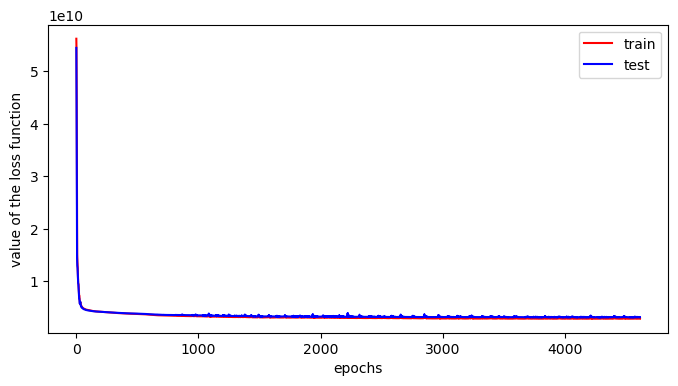

In [138]:
plt.figure(figsize=(8,4))
plt.plot(Ls[:i],color='red',label='train')
plt.plot(Ls_val[:i],color='blue',label='test')
plt.xlabel('epochs')
plt.ylabel('value of the loss function')
plt.axis('tight')
plt.legend()
plt.show()

We now print the results of the test predictions of the trained model

In [139]:
#We load the model with optimal validation score
del model
model = torch.load('best_model',weights_only=False)
with torch.no_grad():
    Y_pred=model(X_test).numpy()

    #computing r2 score
    R2=r2_score(Y_test.numpy(),Y_pred)
    
    # Making predictions

    
    # computing MSE
    mse = mean_squared_error(Y_pred,Y_test)
    
    # computing MAE
    mae =mean_absolute_error(Y_pred,Y_test)
    
    #We print the sqrt(MSE), mae and the R2 score
    print('sqrt(MSE) (test):',np.sqrt(mse)) 
    print('MAE (test):',mae)
    print('R2  (test):',R2)

sqrt(MSE) (test): 55660.39424941221
MAE (test): 38158.37890625
R2  (test): 0.7659363746643066


Best Results for  1 hidden layer, 12 neurons, stepsize=15, early_stopping_step=300 :
- sqrt(MSE) (test): 55660
- MAE (test): 38158
- R2  (test): 0.765

Despite trying multiple models with multiple numbers of hidden layers the model was not able to reach a test MAE as good as the one from XGBoost.

# Conclusion

We started with a mean absolut error of around $50000$ (R2=0.62) using linear models. Using Trees, Random Forest and Neural Networks we were able to reduce the MAE to a $\left[37000,39000\right]$ range (R2 $\in \left[0.74,0.77\right]$) and by using XGBoost, we were able to reduce the test MAE to 29000 (R2=$0.84$). These results are not really satisfying in a real life context (we would like to estimate house prices more precisely) but it would be very difficult to make better predictions using only these features.